# 导入包

In [20]:
# print(os.getcwd())
%cd ..
import tensorflow_advanced_segmentation_models as tasm
%cd examples

/data111/bianhao/wyh/TensorFlow-Advanced-Segmentation-Models
/data111/bianhao/wyh/TensorFlow-Advanced-Segmentation-Models/examples


In [21]:
import numpy as np
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow.keras.backend as K
from IPython.display import clear_output

# 加载数据集
tfds.load是一种方便的方法，它是构建和加载tf.data.Dataset的最简单方法。
https://www.tensorflow.org/datasets/api_docs/python/tfds/load


In [22]:

dataset, info = tfds.load('caltech_birds2010', download=False, data_dir='../data', with_info=True)


In [23]:
for k, v in dataset.items():
    print(k, ':', v)

train : <PrefetchDataset element_spec={'bbox': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None)}>
test : <PrefetchDataset element_spec={'bbox': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None)}>


## 定义参数和变量

In [24]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 4
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
N_CLASSES = 2
HEIGHT = 320
WIDTH = 320
BACKBONE_NAME = "efficientnetb5"
WEIGHTS = "imagenet"

## 构建训练和评估流水线
您的测试流水线与训练流水线类似，只有几点细微差异：
- 您无需调用 tf.data.Dataset.shuffle。
- 在批处理后进行缓存，因为各个周期之间的批次可以相同。

In [25]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0

    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    # 数据增强
    input_image = tf.image.resize(datapoint['image'], (HEIGHT, WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT, WIDTH))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (HEIGHT, WIDTH))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT, WIDTH))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [26]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [27]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [28]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

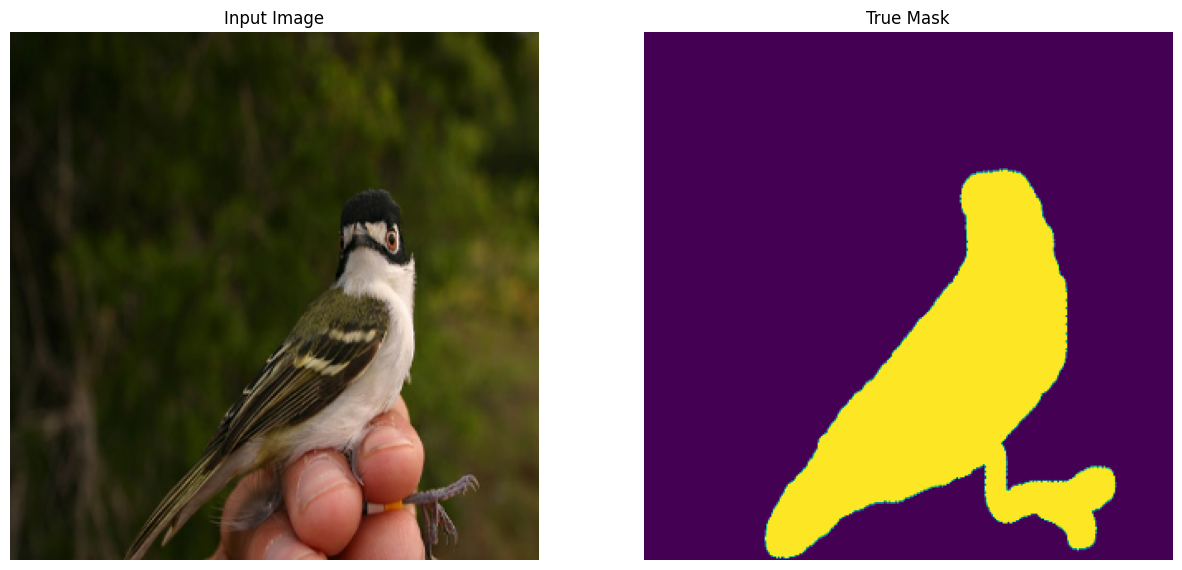

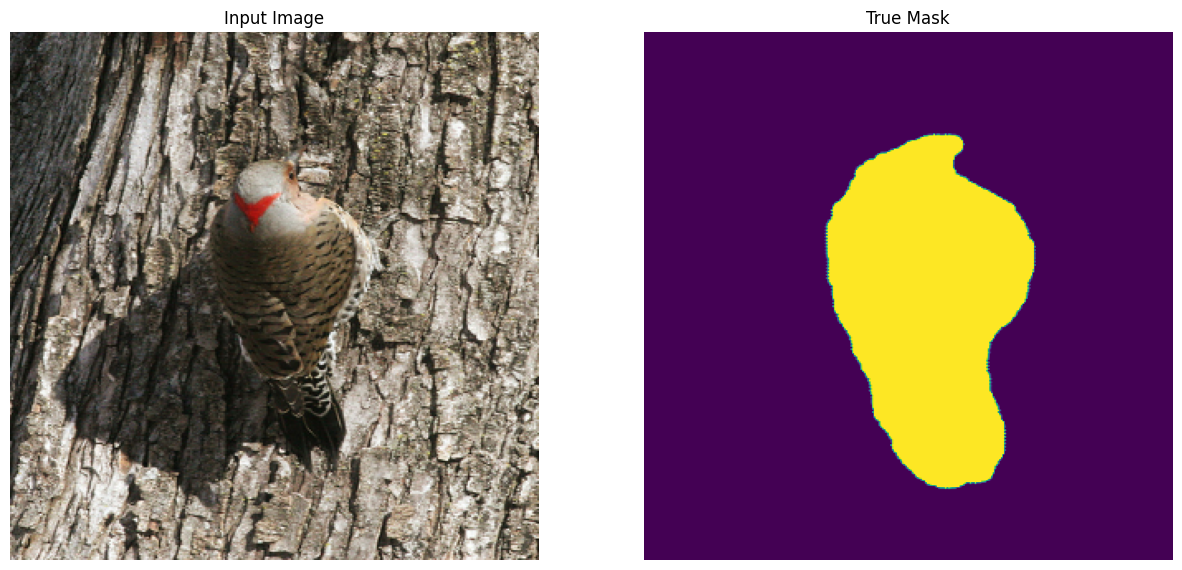

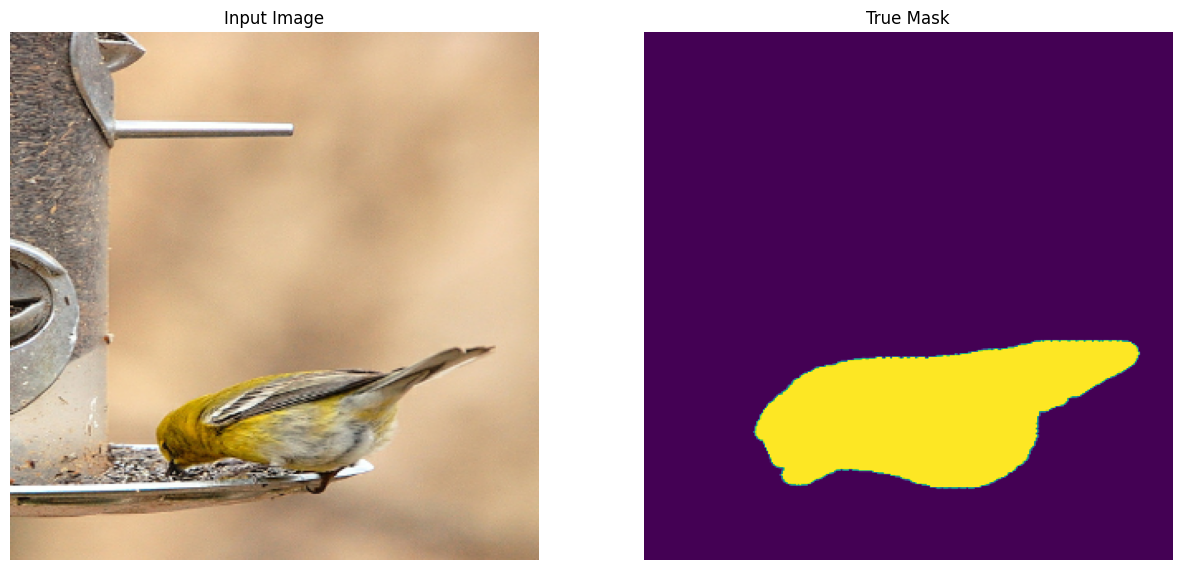

In [30]:
for image, mask in train.take(3): # 调用take(count, name=None)方法
    sample_image, sample_mask = image, mask
    
    display([sample_image, sample_mask])

# 创建并训练模型
https://www.tensorflow.org/datasets/keras_example

In [31]:
base_model, layers, layer_names = tasm.create_base_model(name=BACKBONE_NAME, weights=WEIGHTS, height=HEIGHT, width=WIDTH, include_top=False, pooling=None)

BACKBONE_TRAINABLE = True
model = tasm.UNet(n_classes=N_CLASSES, base_model=base_model, output_layers=layers, backbone_trainable=BACKBONE_TRAINABLE)

In [32]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    # for yet unknown reasons 0s and 1s need to be inverted... something is not working properly in the training pipeline
    # that is why iou_score and val_iou_score are so low while fitting the model...
    pred_mask = pred_mask == 0
    pred_mask = tf.cast(pred_mask, tf.float32)
    return pred_mask[0]

1/1 [==============================] - 23s 23s/step


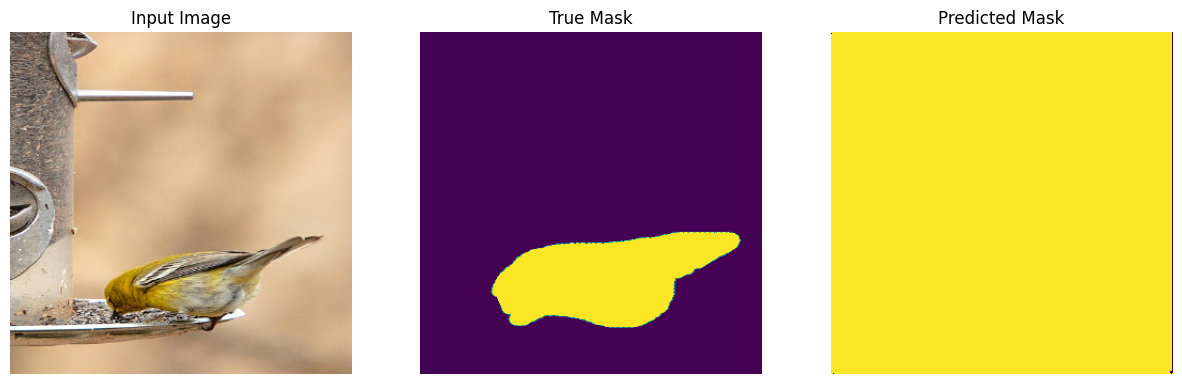

In [33]:
display([
         sample_image,
         sample_mask,
         create_mask(
             model.predict(sample_image[tf.newaxis, ...])
             )
         ])

使用训练和测试数据训练完全未冻结的模型<使整个模型可训练，并另外使用验证集。

In [34]:
for layer in model.layers:
    layer.trainable = True

    print(layer.name + ": " + str(layer.trainable))

model_1: True
convolution_bn_activation_12: True
convolution_bn_activation_13: True
upsample_x2__block_5: True
upsample_x2__block_6: True
upsample_x2__block_7: True
upsample_x2__block_8: True
upsample_x2__block_9: True
conv2d_11: True
activation_1: True


## 定义优化器，损失函数，评价指标和回调函数
- 优化器：https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer?hl=zh-cn
- 调节学习率：https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau?hl=zh-cn
- 早停策略：https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping?hl=zh-cn

In [16]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
metrics = [tasm.metrics.IOUScore(threshold=0.5)]
categorical_focal_dice_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + tasm.losses.DiceLoss()

model.compile(
    optimizer=opt,
    loss=categorical_focal_dice_loss,
    metrics=metrics,
)
model.run_eagerly = True # True, 计算是在运行时被执行的，而不是通过预编译的图来执行（动态图，类似pytorch）。

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", factor=0.2, patience=6, verbose=1, mode="max"),
             tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=16, mode="max", verbose=1, restore_best_weights=True)
]

In [16]:
EPOCHS = 100
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_dataset,
    callbacks=callbacks
    )

Epoch 1/100


2022-11-26 08:47:32.555712: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


750/750 [==============================] - 1933s 3s/step - loss: 0.6144 - iou_score: 0.3715 - val_loss: 0.9591 - val_iou_score: 0.1263 - lr: 0.1000
Epoch 2/100
750/750 [==============================] - 1856s 2s/step - loss: 0.5912 - iou_score: 0.3988 - val_loss: 1.0049 - val_iou_score: 0.1011 - lr: 0.1000
Epoch 3/100
750/750 [==============================] - 1889s 3s/step - loss: 0.5853 - iou_score: 0.4061 - val_loss: 1.0735 - val_iou_score: 0.0824 - lr: 0.1000
Epoch 4/100
750/750 [==============================] - 1837s 2s/step - loss: 0.5866 - iou_score: 0.4039 - val_loss: 1.0009 - val_iou_score: 0.0810 - lr: 0.1000
Epoch 5/100
750/750 [==============================] - 1844s 2s/step - loss: 0.5785 - iou_score: 0.4152 - val_loss: 0.9532 - val_iou_score: 0.1234 - lr: 0.1000
Epoch 6/100
750/750 [==============================] - 1859s 2s/step - loss: 0.5742 - iou_score: 0.4211 - val_loss: 0.9784 - val_iou_score: 0.0884 - lr: 0.1000
Epoch 7/100
750/750 [==============================]

In [27]:
import os
import pickle
result_dir = 'logs'
os.makedirs(result_dir, exist_ok=True)
# model.save(f"{result_dir}/unet.h5")
model.save_weights(f"{result_dir}/unet_weight.h5")
f = open(f"{result_dir}/history_unet","wb")
pickle.dump(history.history,f)
f.close()

- 加载训练好的模型

In [38]:
import pickle
result_dir = 'logs'

# model.load_weights(f"{result_dir}/unet_weight.h5")
f = open(f"{result_dir}/history_unet","rb")
history2 = pickle.load(f)
f.close()

## 画训练IOU和损失函数曲线

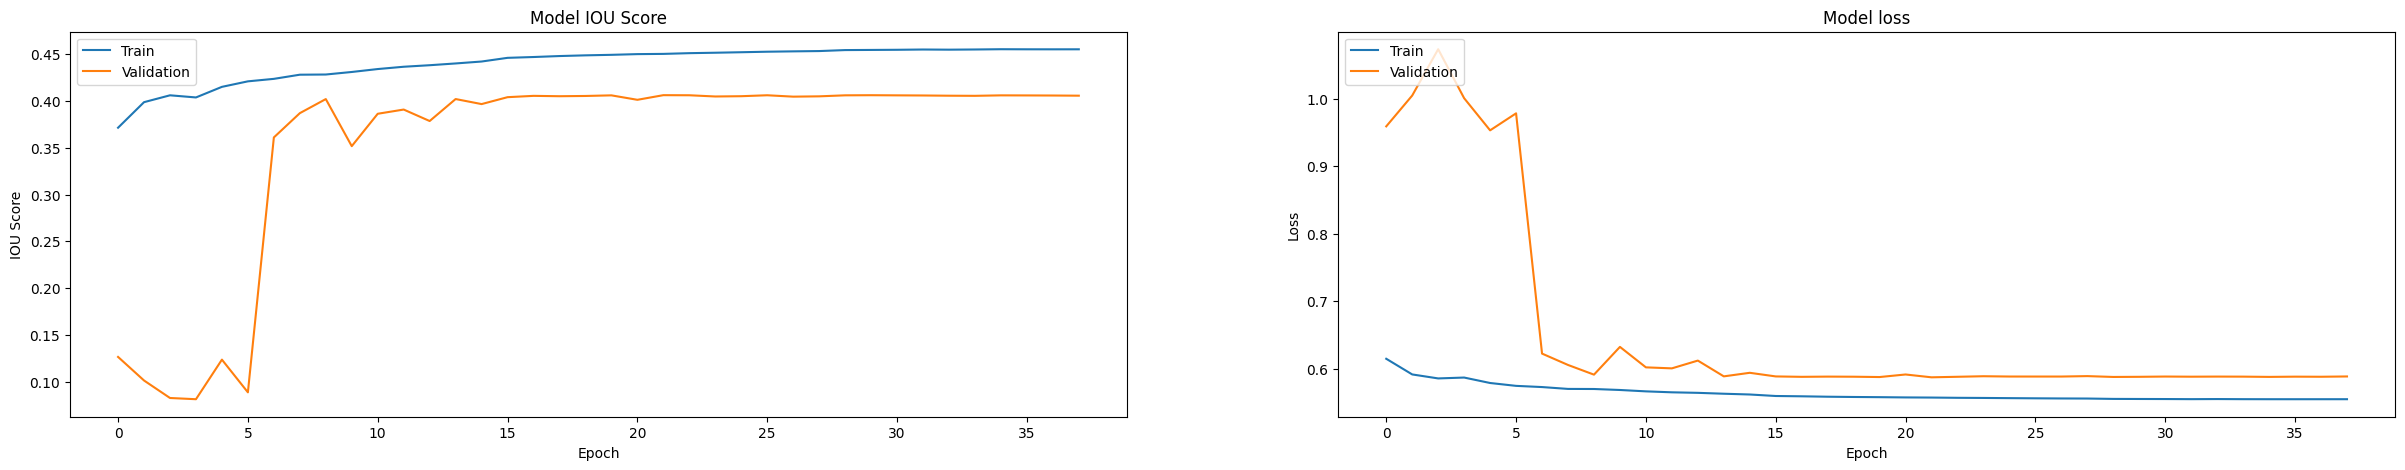

In [36]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history2['iou_score'])
plt.plot(history2['val_iou_score'])
plt.title('Model IOU Score')
plt.ylabel('IOU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history2['loss'])
plt.plot(history2['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model IOU Score')
plt.ylabel('IOU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 评估
## 测试数据可视化示例

1/1 [==============================] - 0s 81ms/step


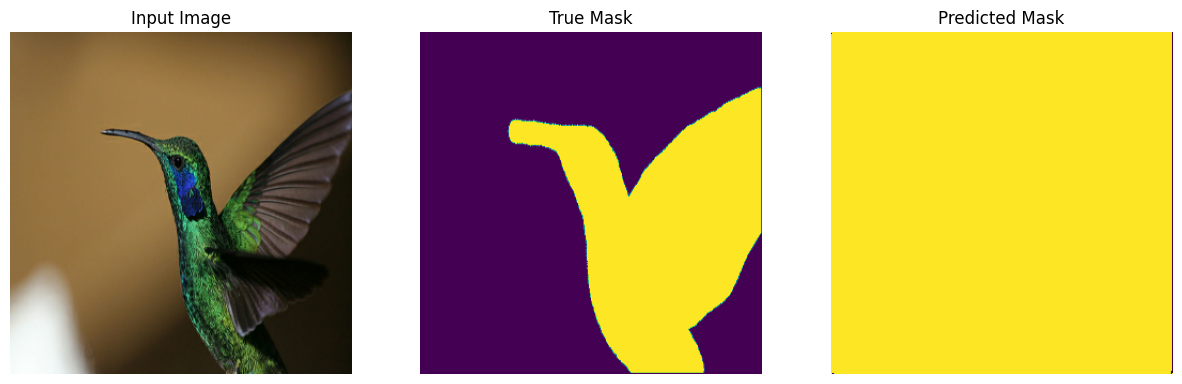

1/1 [==============================] - 0s 92ms/step


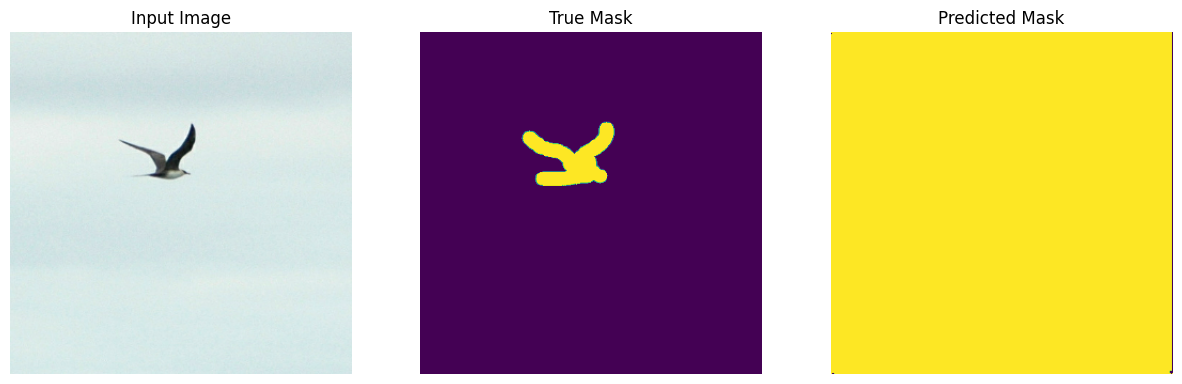

1/1 [==============================] - 0s 82ms/step


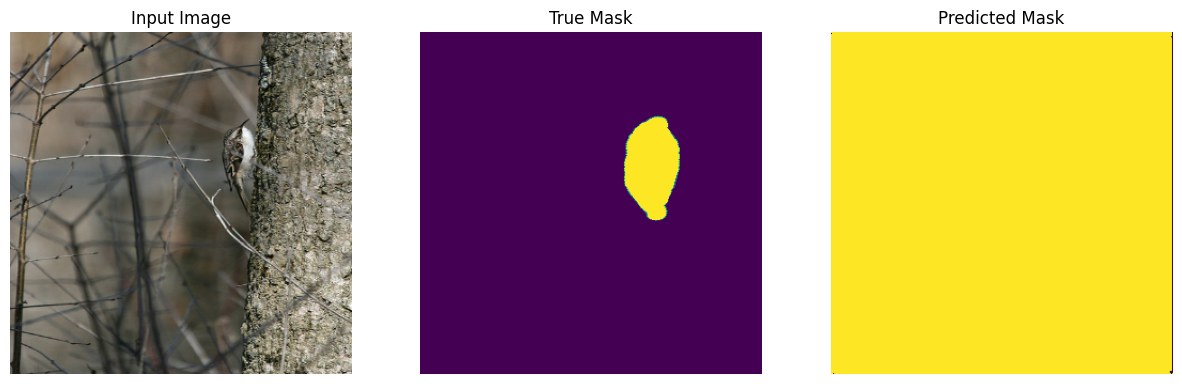

1/1 [==============================] - 0s 92ms/step


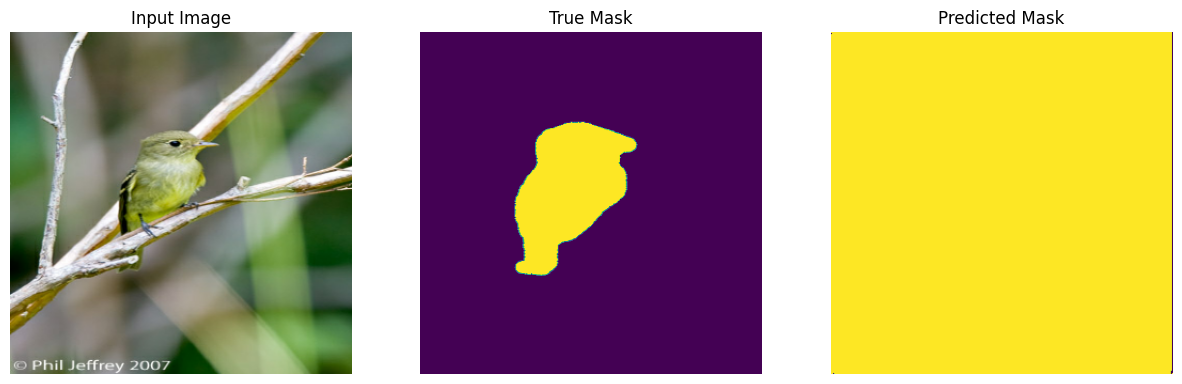

1/1 [==============================] - 0s 71ms/step


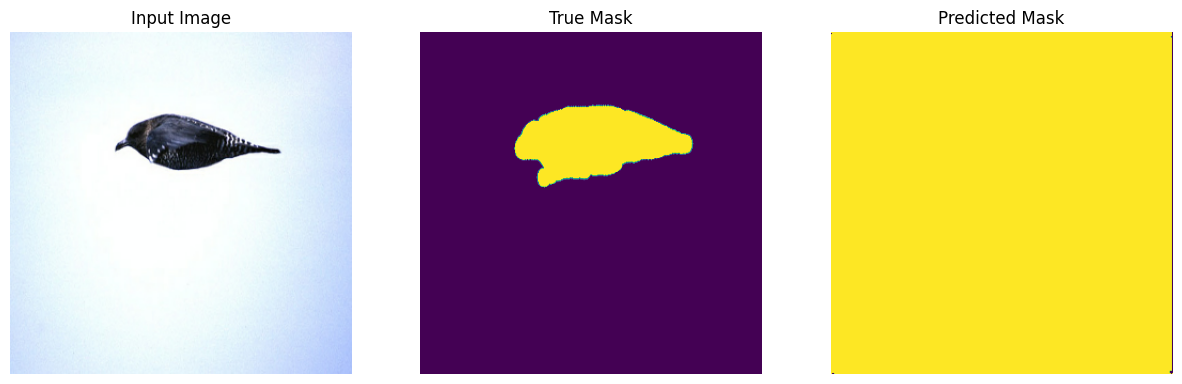

In [39]:
iou_scores = 0

for image, mask in test.take(5):
    sample_image, sample_mask = image, mask

    output_model = model.predict(sample_image[tf.newaxis, ...])
    
    display([
                sample_image,
                sample_mask,
                create_mask(output_model)
                ])
    # print(create_mask(output_model))

## 手动计算2500张图片的测试IOU分数

In [30]:
iou_scores = 0

for image, mask in test.take(2500):
    sample_image, sample_mask = image, mask

    output_model = model.predict(sample_image[tf.newaxis, ...])
    
    iou_score = tasm.losses.iou_score(sample_mask, create_mask(output_model)).numpy()
    iou_scores += iou_score

print("Mean IoU-Score: " + str(iou_scores))

1/1 [==============================] - 1s 1s/step
